In [43]:
import os
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

sys.path.insert(0,'/ncluster/newton')
import util as u
import importlib
importlib.reload(u)

import matplotlib
%matplotlib inline

# Line-search

In [52]:
import kfac_pytorch as kfac_lib
import importlib
importlib.reload(kfac_lib)
losses_adam, vlosses_adam, model = kfac_lib.train(iters=10, kfac=False, print_interval=1)
u.summarize_time()

Step   0 loss 97.542419434
Step   1 loss 32.184158325
Step   2 loss 31.059148788
Step   3 loss 30.073652267
Step   4 loss 28.751443863
Step   5 loss 28.019514084
Step   6 loss 27.574556351
Step   7 loss 27.251935959
Step   8 loss 27.024276733
Step   9 loss 26.863996506
Times: min: 45.69, median: 45.95, mean: 138.83


In [53]:
dsize=10000
dtype=np.float32
fs = [dsize, 28*28, 1024, 1024, 1024, 196, 1024, 1024, 1024, 28*28]
n = len(fs) - 2   # number of matmuls

images = u.get_mnist_images()
train_data0 = images[:, :dsize].astype(dtype)
train_data = torch.from_numpy(train_data0).cuda()

In [82]:
def copy_parameters(model):
    original_param_data_list = []
    for p in model.parameters():
        param_data = p.data.new(p.size())
        param_data.copy_(p.data)
        original_param_data_list.append(param_data)
    return original_param_data_list

def reset_parameters(model):
    original_param_data_list = []
    for current_param, param0 in zip(model.parameters(), parameters0):
        current_param.data.copy_(param0)

def zero_grad(model):
    for p in model.parameters():
        if p.grad is not None:
            p.grad.detach_()
            p.grad.zero_()
            
def compute_loss():
    error = model(train_data)-train_data
    return torch.sum(error*error).detach().cpu().numpy()/2/dsize

def advance(model, lr, layer_idx=-1):
    """Advances model parameters in direction of gradient by fraction lr"""
    params = list(model.parameters())
    if layer_idx == -1:
        pass
    else:
        params = [params[layer_idx]]
    for p in params:
        p.data.copy_(p.data + lr*p.grad.data)

In [55]:
reset_parameters(model)
error = model(train_data)-train_data
loss = torch.sum(error*error)/2/dsize
zero_grad(model)
loss.backward()
torch.sum(error*error)/2/dsize

tensor(26.7531, device='cuda:0', grad_fn=<DivBackward0>)

In [56]:
advance(model, .1)
error = model(train_data)-train_data
torch.sum(error*error)/2/dsize

tensor(27.1546, device='cuda:0', grad_fn=<DivBackward0>)

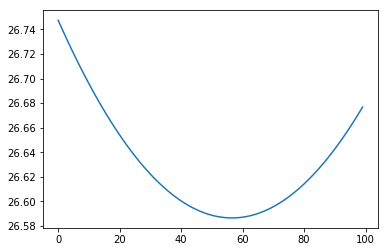

In [58]:
reset_parameters(model)
vals = []
reset_parameters(model)
for i in range(100):
    advance(model, -.002)
    error = model(train_data)-train_data
    vals.append(torch.sum(error*error).detach().cpu().numpy()/2/dsize)
    
import matplotlib.pyplot as plt
plt.plot(vals)

### Optimize for one layer

Step   0 loss 97.542419434
Step   1 loss 32.184158325
Step   2 loss 31.059148788
Step   3 loss 30.073652267
Step   4 loss 28.751443863
Step   5 loss 28.019514084
Step   6 loss 27.574556351
Step   7 loss 27.251935959
Step   8 loss 27.024276733
Step   9 loss 26.863996506
Times: min: 45.97, median: 46.14, mean: 139.48


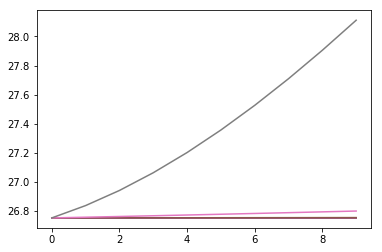

In [140]:
import kfac_pytorch as kfac_lib
import importlib
importlib.reload(kfac_lib)
losses_adam, vlosses_adam, model = kfac_lib.train(iters=10, kfac=False, print_interval=1)
parameters0=copy_parameters(model)
u.summarize_time()
loss0 = compute_loss()

n = 8
val_array = []
for layer_idx in range(n):
    vals = []
    reset_parameters(model)
    for i in range(10):
        error = model(train_data)-train_data
        vals.append(torch.sum(error*error).detach().cpu().numpy()/2/dsize)
        advance(model, -.2/n, layer_idx)
    plt.plot(vals)
    val_array.append(vals)